<a href="https://colab.research.google.com/github/Dagobert42/langID-NLP/blob/master/langID_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Dataset Preparation
This subsection contains methods to produce uniformly distributed chunks of our data set. From these we can then obtain n-grams of different sizes. The Wikipedia Language Identification database contains txt-files of x_train and x_test for example sentences and accordingly ordered labels in y_train, y_test.

In [165]:
import numpy as np
import pandas as pd
import string, re, time, math
import nltk
from nltk import ngrams
import collections
from collections import defaultdict
from collections import Counter
from IPython.display import clear_output

In [166]:
!npx degit Dagobert42/langID-NLP/WiLI-2018_data -f

npx: installed 1 in 0.949s
> destination directory is not empty. Using --force, continuing
> cloned Dagobert42/langID-NLP#master


In [183]:
# read data
# written for the WiLI-2018 data set: https://zenodo.org/record/841984
X_train = open('x_train.txt', encoding="utf8").read().split('\n')
Y_train = open('y_train.txt', encoding="utf8").read().split('\n')
X_test = open('x_test.txt', encoding="utf8").read().split('\n')
Y_test = open('y_test.txt', encoding="utf8").read().split('\n')
labels = pd.read_csv('labels.csv', delimiter = ';')

In [168]:
# preprocessing the data
def preprocess(X,Y):

    # convert language labels to language Name => 'en' -> 'English'
    lab_dict = { labels.loc[i]['Label'] : labels.loc[i]['English'] for i in range(0, len(labels)) }
    y_train = [ lab_dict[item] if item != 'nan' else 'Min Nan Chinese' for item in Y ]

    # remove unnecessary characters from data
    extras = '!"$%&/{}[]()=?\\`´*+~#-_.:,;<>|1234567890°-\''
    rx = '[' + re.escape(''.join(extras)) + ']'
    x_train = [] 
    to_remove = []
    i = 0
    for example in X:
        processed = re.sub(' +', ' ', re.sub(rx, '', example))
        # some examples only contain spaces after preprocessing
        # this is a check for those examples
        if len("".join(processed.split())):
            x_train.append(processed)
        else:
            y_train.pop(i)
        i+=1

    return x_train,y_train

# Output example:
# x_train = [ex1, ex2, ex3, ...]
# y_train = [lang_of_ex1, ...]

In [169]:
# sort data by language
def data_by_lang(X, Y):
    lang_corpora = defaultdict(list)
    lang_idx = defaultdict(list)
    for i in range(len(X)):
        lang_corpora[Y[i]].append(X[i])
        lang_idx[Y[i]].append(i)

    return lang_corpora, lang_idx
    
# Output example:
# lang_corpora = { 'Lang1' : [ex1, ex2, ...], 'Lang2' : [ex1, ex2, , ...], ...}
# land_idx = { 'Lang1' : [23, 41, ...], 'Lang2' : [1, 19, ...], ...}

In [170]:
# extract uniformly distributed list of examples from our data set
# takes an optional argument to constrain the list of languages
def get_data_chunk(X, Y, n_samples, lang_keys=[]):
    _, lang_idx = data_by_lang(X, Y)
    x_train = []
    y_train = []
    
    langs = set()
    if lang_keys: 
        langs = set(lang_keys)
    else:
        langs = set(Y)

    for lang in langs:
        indices = lang_idx[lang]
        if(len(indices) < n_samples):
          n_samples = len(indices)
        for index in range(n_samples):
            x_train.append(X[indices[index]])
            y_train.append(Y[indices[index]])

    return x_train, y_train

# Output example:
# x_train [ lang1_ex1, lang1_ex2, ..., lang2_ex, lang2_ex, ...]
# y_train [ lang1, lang1, ...lang2, lang2, ...]

In [171]:
# creating n-grams for each data entry
# optional arguments:
#    lang_keys - constrains the languages to use
#    stepsize  - specifies the amount of characters
#                to jump until the next n-gram
# returns a list of n-grams
def make_n_grams(X, Y, n, lang_keys=[], stepsize=1):
    assert stepsize >= 1
    x_to_grams = []

    langs = set()
    if lang_keys: 
        langs = set(lang_keys)
    else:
        langs = set(Y)

    for i in range(len(X)):
        if Y[i] in langs:
            sent = X[i]
            x_to_grams.append([sent[j:j+n] for j in range(0, len(sent) - n+1, stepsize)])

    return x_to_grams

# Output example:
# x_to_grams = [[ngram_in_ex1], [ngram_in_ex2], ...]

In [172]:
# counting and sorting n-grams for each language
# returns a sorted dict of lang : {n-gram : count}
def sort_by_tf(X, Y):
    # calculating term frequency of n-grams per language
    tf_per_lang = defaultdict(list)
    langs = set(Y)
    data, _ = data_by_lang(X, Y)
    for lang,gram_list in data.items():
      data[lang] = [ gram for grams in gram_list for gram in grams] # Comvert list of lists to a single list
    for lang in langs:
        tf_per_lang[lang] = dict(
            zip(list(Counter(data[lang]).keys()),
                 list(Counter(data[lang]).values())))

    # sort by term frequency
    sorted_tf_per_lang = defaultdict(list)
    for lang in langs:
        sorted_tf_per_lang[lang] = { word : value for word, value in sorted(tf_per_lang[lang].items(), key=lambda item:item[1], reverse=True) }
    
    return sorted_tf_per_lang
# Output example:
# sorted_tf_per_lang = { lang1 : {n_gram1 : count}, ...}

### 2. Understanding Data
n the following we review some examples to get an understanding of our data.
Particularly interesting are languages with a degree of similarity, as these are a greater challenge for classification. Here we print examples of n-grams from languages that use the Latin alphabet.
Starting with trigrams, and taking the 20 most common from each language, we see that many languages have a few in common. This is above all the case with languages which are closely related. Here we have examples from the Latin family, the Germanic family, and single examples from their families (Estonian, Turkish). At the trigram level, we even see plenty of intersection between languages which aren't related at all (French, Estonian), or only distantly (German, Romanian).

In [173]:
import matplotlib
import matplotlib.pyplot as plt

In [174]:
def make_barplots(n_gram_size, lang_key, commoncollect, base_counts, compare_counts, otherlangs, concise=True):
    width = 0.35  # the width of the bars
    if len(otherlangs) > 6 and concise==False:
        nrows = 3
        ncols = 3
        figsize=(22, 10)
    elif len(otherlangs) > 4 and concise==False:
        nrows = 2
        ncols = 3
        figsize=(22, 10)
    elif len(otherlangs) > 1 and concise==False:
        nrows = 1
        ncols = len(otherlangs)
        if len(otherlangs) == 4:
            figsize=(26, 5)
        else:
            figsize=(18, 4)
    elif len(otherlangs) == 1 or concise==True:
        try:
            fig, ax = plt.subplots(figsize=(7, 4))
            fig.suptitle('Frequency of %s-grams in %s compared to %s:' % (n_gram_size, lang_key, otherlangs[0]),  fontsize=16)
            x = np.arange(len(commoncollect[0]))  # the label locations   
            rects1 = ax.bar(x - width/2, base_counts[0], width, color = 'r', label=lang_key)
            rects2 = ax.bar(x + width/2, compare_counts[0], width, color = 'g', label=otherlangs[0])
            ax.set_xticks(x)
            ax.set_xticklabels(commoncollect[0], fontsize=14)
            ax.legend(fontsize=12)
            plt.show()
        except IndexError:
            print('there was an IndexError')
            return
        return

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharey = 'row', figsize=figsize)
    fig.suptitle('Frequency of %s-grams in %s compared to other languages:' % (n_gram_size, lang_key),  fontsize=20)
    for ax, common_ngrams, counts_langkey, counts_otherlang, otherlang in zip(axes.flatten(), commoncollect, base_counts, compare_counts, otherlangs):
        x = np.arange(len(common_ngrams)) 
        rects1 = ax.bar(x - width/2, counts_langkey, width, color = 'r', label=lang_key)
        rects2 = ax.bar(x + width/2, counts_otherlang, width, color = 'g', label=otherlang)
        ax.set_xticks(x)
        ax.set_xticklabels(common_ngrams, fontsize=14)
        ax.legend(fontsize=12)
        
    return

As we increase the size of our n-grams, the number of examples declines dramatically, as does the intersection between the commonest n-grams in various languages. Even at 4-grams, we see that the Germanic and Latin families are delineated from each other. Higher than that, and only the Latin languages still have some n-grams in common with each other, at least among the top 20 most frequent. This suggests that longer n-grams can more quickly lead to accurate identification of a language.

In [230]:

x_train, y_train = preprocess(X_train[:-1],Y_train[:-1])

latin_languages = ['German', 'English', 'French', 'Spanish', 'Italian', 'Portuguese', 
                    'Estonian', 'Turkish', 'Romanian', 'Swedish', 'Latin', 'Dutch']
                    
# produces charts of counts of common n-grams in different languages, and tables suggesting similar languages based on these

for n_gram_size in range(3,7):
    m_samples = 20

    ng_related = {}
    
    x_train_grams = make_n_grams(x_train, y_train, n_gram_size, stepsize = n_gram_size)
    sorted_tf_per_lang = sort_by_tf(x_train_grams, y_train)

    for lang_key in latin_languages:

        ng_related[lang_key] = []
        latin_languages.remove(lang_key)
        latin_langs = latin_languages
        top_m = list(sorted_tf_per_lang[lang_key].keys())[:m_samples]

        commoncollect, base_counts, compare_counts, otherlangs = [], [], [], []

        for otherlang in latin_langs:
            top_m_x = list(sorted_tf_per_lang[otherlang].keys())[:m_samples]
            common_ngrams = list(set(top_m).intersection(top_m_x))
            
            if len(common_ngrams) > 2:
                
                ng_related[lang_key].append(otherlang)
                
                # get counts of the entries in common_ngrams for each language.
                # These are stored as the values corresponding to the n-gram keys in the dictionary
                counts_langkey = []
                counts_otherlang = []
                for i in common_ngrams:
                    counts_langkey.append(sorted_tf_per_lang[lang_key][i])
                    counts_otherlang.append(sorted_tf_per_lang[otherlang][i])

                common_ngrams = [k.replace(' ', '_') for k in common_ngrams]
                
                #print(lang_key, "and", otherlang, "have the following frequent", n_gram_size,"-grams in common:",common_ngrams)
                #print('\n ')

                commoncollect.append(common_ngrams)
                base_counts.append(counts_langkey)
                compare_counts.append(counts_otherlang)
                otherlangs.append(otherlang)

        if commoncollect:
        # this sorting operation is to position the largest n-gram intersections at the top of the lists.
            commoncollect, base_counts, compare_counts, otherlangs = zip(*sorted(zip(commoncollect, base_counts, compare_counts, otherlangs), key=lambda x: len(x[0]), reverse=True))
 
            # set parameter "concise" to False if you want an extensive set of bar charts in the output
            make_barplots(n_gram_size, lang_key, commoncollect, 
                          base_counts, compare_counts, otherlangs, concise=True)
        
        latin_languages = ['German', 'English', 'French', 'Spanish', 'Italian', 'Portuguese', 
                           'Estonian', 'Turkish', 'Romanian', 'Swedish', 'Latin', 'Dutch']                    
    
    print('similar languages based on ', n_gram_size, '- grams:')
    for key, val in ng_related.items():
        print(key, ':', val)
    
    print('\n ')

#time.sleep(120)
#clear_output()


### 3. Naive Bayes Classifier
To obtain a baseline for the language identification task we employ a Gaussian Naive Bayes classifier.


In [176]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
import time, math, random

In [177]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [178]:
# extracts lists of top n frequent n-grams from data
def get_top_n_features(X_grams, Y, n_features):
  '''
  X : [[ngram_in_ex1], [ngram_in_ex2], ...]
  Y : ['lang1', 'lang1', ..., 'lang2', ...]
  n_features : number of ngram to pick from each language
  '''
  sorted_freq_per_lang = sort_by_tf(X_grams, Y)
  features = []
  for lang, grams_dict in sorted_freq_per_lang.items():
      i = 0
      for gram, count in grams_dict.items():
          if i <= n_features:
              features.append(gram)
          else:
              break
          i += 1
      
  return list(set(features))
# Output example:
# features : ['and', 'he ', 'öä ', ...]

In [179]:
# convert data to feature matrix
def create_feature_matrix(X, features):
  '''
  X : [[ngram_in_ex1], [ngram_in_ex2], ...]
  features : ['and', 'he ', 'öä ', ...] top ngrams from corpus

  '''
  mat = np.zeros((len(X),len(features)))
  i = 0
  for gram_list in X:
      gram_count = []
      for gram in features:          
          if gram in gram_list:
              gram_count.append(gram_list.count(gram)+1)
          else:
              gram_count.append(1)
      mat[i] = gram_count
      i+=1

  return mat
  # mat : array([[4,1,2,1,...],[1,1,1,2,3,1,...],...])

In [180]:
n_instances = 500 # instance per language, must be less than 500
n_gram_size = 4
n_features = 20 # features per language
n_lang = 11
start = time.time()
print("Starting preprocessing at {} ..".format(time_since(start)))

x_train, y_train = preprocess(X_train[:-1], Y_train[:-1])

print("Preprocessing Done at {}.".format(time_since(start)))

avail_lang = list(set(y_train))
rand_idx = random.sample(range(0,235),n_lang)
lang_group = np.array(avail_lang)[rand_idx] # Selecting n_lang random language for training

# reduce languages to get smaller data subset
x_train, y_train = get_data_chunk(x_train, y_train, n_instances,dsl_groups_ABC)

print("Making ngrams at {} ..".format(time_since(start)))
x_train_grams = make_n_grams(x_train, y_train, n_gram_size)

print('Extracting features at {} ...'.format(time_since(start)))
# create features for dataset
features = get_top_n_features(x_train_grams, y_train, n_features)

print('Creating feature matrix at {}  ....'.format(time_since(start)))
# convert dataset into feature matrix
feature_matrix = create_feature_matrix(x_train_grams, features)
print('Data Preperation completed after {}'.format(time_since(start)))

Starting preprocessing at 0m 0s ..
Preprocessing Done at 0m 3s.
Making ngrams at 0m 3s ..
Extracting features at 0m 3s ...
Creating feature matrix at 0m 4s  ....
Data Preperation completed after 0m 7s


In [181]:
'''
# Gaussian Naive Bayes Model Training
encoder = LabelEncoder()
X = feature_matrix
Y = encoder.fit_transform(y_train)
model = GaussianNB()
model.fit(X,Y)
'''


'\n# Gaussian Naive Bayes Model Training\nencoder = LabelEncoder()\nX = feature_matrix\nY = encoder.fit_transform(y_train)\nmodel = GaussianNB()\nmodel.fit(X,Y)\n'

In [182]:
# model testing
start = time.time()
print('Test Data preperation starting ...')
x,y = preprocess(X_test[:-1], Y_test[:-1])

n_instances = 500

x,y = get_data_chunk(x,y,n_instances, dsl_groups_ABC)

print("Making ngrams at {} ..".format(time_since(start)))
x_test_grams = make_n_grams(x, y, n_gram_size)

print('Creating feature matrix at {}  ....'.format(time_since(start)))
x = create_feature_matrix(x_test_grams, features)
print('Test Data Preperation completed after {}'.format(time_since(start)))

y = encoder.fit_transform(y)
y_pred = model.predict(x)

Test Data preperation starting ...
Making ngrams at 0m 3s ..
Creating feature matrix at 0m 4s  ....
Test Data Preperation completed after 0m 6s


NameError: ignored

In [ ]:
# Model Evaluation

acc = round(accuracy_score(y_pred=y_pred, y_true=y), 4) * 100
print(f"Accuracy is {acc}%")

f1score = f1_score(y,y_pred,average='weighted')
print(f"f1-score is {f1score}")

y1 = encoder.inverse_transform(y)
y2 = encoder.inverse_transform(y_pred)
conf_matrix = confusion_matrix(y_pred=y2, y_true=y1)
df_cm = pd.DataFrame(conf_matrix/conf_matrix.astype(np.float).sum(axis=1), columns=np.unique(y1), index = np.unique(y1))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,10))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm,annot=True,fmt=".2f",linewidths=1.5)

### 4. Recurrent Neural Network

In this section we introduce a Recurrent Neural Network (RNN) model for language identification task. The model is of a many-to-one type, meaning that we provide a sequence of data units (n-grams in our case) to multiple RNN cells which produces an output at the last cell.

In [184]:
import torch
from torch.autograd import Variable 
import torch
import torch.nn as nn
import torch.nn.functional as F

In [185]:
# helper to print progress bars of this length
bar_len = 20

**CHANGE TO GPU MODE**

In [186]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

There are three layers in this model. First is an Embedding Layer which converts input data into embeddings, second is a Gated Recurrent Unit and finally a Linear Layer to provide the probability distribution over different languages.

In [187]:
class RNN(nn.Module):
    def __init__(self, input_size, hid_size, output_size, layers, embedding):

        super(RNN, self).__init__()
        self.hidden_dim = hid_size
        self.layers = layers
        self.embedding_size = embedding 
        self.dropout = nn.Dropout(0.4)
        self.input_size = input_size
        self.output_size = output_size
        self.embeddings = nn.Embedding(self.input_size,self.embedding_size)
        self.rnn = nn.GRU(input_size=self.embedding_size,hidden_size=self.hidden_dim,num_layers = self.layers)
        self.linear = nn.Linear(self.hidden_dim,self.output_size)

    
    def forward(self, x):
        # x : B x S where B is batch size and S is sequence size
        # Sequence size is length of one ngram vector encoding
        batch_size = x.size(0) 
        x = x.t() 
        embedded = self.embeddings(x) # S x B x I , here I is input_size/vocab size
        hidden = self._init_hidden(batch_size)
        output,hidden = self.rnn(embedded,hidden)
        output = self.dropout(output) 
        fc_output = self.linear(output[-1]) # B x L , L is number of classes/languages
        return fc_output

    def _init_hidden(self,batch_size):
        hidden_state = torch.zeros(self.layers,batch_size, self.hidden_dim, device=device)
        return hidden_state

First we extract a number of samples from each language of the given corpus. It is also possible to constrain the data to a subset of languages. Each instance in this reduced dataset is converted into n-grams of a fixed length. Our vocabulary is created by choosing a number of top n-grams by term-frequency and then mapping them to an index which we can use to create encodings.

In [188]:
def prepare_data(X, Y, n_samples, n_gram_size, n_features, lang_keys=[]):
    '''
    Data is prepared in 3 steps:
    1. ngram is created from given dataset i.e each example is converted into a list of ngram
    2. These ngrams are used to create vocabulary
    3. Finally dataset is converted into encodings to feed into RNN
    '''

    # reduce languages to get smaller data subset
    print('Preparing', n_samples, 'samples per language')
    x_train, y_train = get_data_chunk(X, Y, n_samples, lang_keys)

    print('Making', str(n_gram_size) + '-grams at {} ..'.format(time_since(start)))
    x_train_grams = make_n_grams(x_train, y_train, n_gram_size, lang_keys)

    # create features for dataset
    print('Extracting', n_features, 'features at {} ...'.format(time_since(start)))
    features = get_top_n_features(x_train_grams, y_train, n_features)
    vocabulary = {word: i for i, word in enumerate(features)}

    inp, target, _ = create_encodings(x_train_grams, y_train, vocabulary)
    return vocabulary, inp, target, 

N-grams in each example are converted into encodings using our indeces. For each sample, if an n-gram is present in our vocabulary, its index is used as an encoding. This results in a vector of integers for each example. However, these vectors can be of different lengths, which might create problems when we train a model with a batch of input data. So in order to make vectors of equal length we pad it with zeros at the end.

In [189]:
def create_encodings(X_grams, Y, vocabulary):
    '''
    X_grams : [[ngram_in_ex1],[ngram_in_ex2],....]
    Y : ['lang1','lang1',...,'lang2',....]
    vocabulary : {' of':1,'apf':2,....}
    '''
    x_grams = []
    y_grams = []
    gram_len = []
    iter = len(X_grams)/10
    print('Creating Encoding for X')
    for j in range(len(X_grams)):
        gramlist = X_grams[j] # list of ngrams in example j
        gramlist = list(dict.fromkeys(sorted(gramlist,key=gramlist.count,reverse=True)))
        grams = [vocabulary[w] for w in gramlist if w in list(vocabulary.keys()) ] 
        
        if (len(grams) >= 1): # resulting grams list must not be empty
            x_grams.append(grams) # Add encodings to x_grams
            gram_len.append(len(grams)) # Add corresponding data
            y_grams.append(Y[j])

        if (j % iter == 0):
            print('\r{}% data prepared at time {}'.format((j/len(X_grams))*100, time_since(start)), end=' ')
    
    print('\r{}% data prepared at time {}'.format(100, time_since(start)), end=' ')
    gram_len = torch.LongTensor(gram_len)
    inp = padding(x_grams,gram_len)

    print('\nCreating Encoding for Y')
    label = list(set(y_grams))
    labels_to_idx = { lang:i  for i,lang in enumerate(label)}
    y_label = torch.zeros(len(y_grams),device=device).long()
    for i in range(len(y_label)):
        y_label[i] = labels_to_idx[y_grams[i]]
    target = Variable(torch.cuda.LongTensor(y_label))
    return inp, target, labels_to_idx

  # inp : tensor([[12, 342, ..., 0],[56, 2311, ...], ...])
  # target : tensor([41, 127, 234, 16, ...])

In [190]:
def padding(vector_inps, lengths):
    '''
    This function takes variable lengths vectors and convert them into equal length by padding 0.
    Input : "vector_inps" list of vectors containing indices of ngrams
            "lengths " length of each vector
    Output : Tensor containing vectors of equal length after padding
             This length is equal to maximum number(M) in list of "lengths"
    '''
    inp_tensor = torch.zeros((len(vector_inps),lengths.max()), device= device).long()
    for idx, (seq, seq_len) in enumerate(zip(vector_inps,lengths)):
        inp_tensor[idx, :seq_len] = torch.LongTensor(seq)
    return inp_tensor

    # inp_tensor : tensor([[12, 342, ..., 0], [56, 2311, ...], ...])

In [191]:
def start_training(X, Y, input_size, hidden_size=64, n_layers=1, embedding_size=64, lr=0.001, batch=64, n_epochs=1000):
    output_size = len(set(Y.cpu().numpy())) # number of languages
    model = RNN(input_size, hidden_size, output_size, n_layers, embedding_size).to(device)
    decoder_optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    print_every = n_epochs/10
    all_losses = []
    f1_scores = []
    print('Training:')
    for epoch in range(1, n_epochs+1):
        loss, score = train(model, criterion, decoder_optimizer, X, target, batch)
        all_losses.append(loss)
        f1_scores.append(score)
        if(epoch % print_every == 0):
            i = math.ceil(epoch/n_epochs * bar_len)
            print('\r', '#' * i, ' ' * (bar_len-i), epoch/n_epochs * 100, '%',
                  '[{} epoch: {} loss: {:.4f}]'.format(time_since(start), epoch, loss), end=' ')
    return model, all_losses, f1_scores

In [192]:
def train(decoder, criterion, decoder_optimizer, inp, target, batch = 100):
    '''
    decoder : Model
    inp : tensor([[12, 342, ..., 0],[56, 2311, ...], ...])
    target : tensor([41, 127, 234, 16, ...])
    '''
    decoder.zero_grad()
    loss = 0
    score = 0
    for i in range(1,int(len(inp)/batch)):
        # input to model should be in form B x S where B is batch size and S is sequence size
        output = decoder(inp[(i-1) * batch: (i) * batch].view(batch, -1))
        loss += criterion(output, target[(i-1)*batch:(i)*batch])
        out = output.argmax(dim=1)
        score += f1_score(target[(i-1)*batch:(i)*batch].cpu().numpy(),out.cpu().numpy(),average='weighted')
    loss.backward()
    decoder_optimizer.step()
    score = score/int(len(inp)/batch)

    return loss.item(), score

In [205]:
def predict(model, test_x, test_y, labels_map):
    '''
    decoder : Model
    test_x  : tensor([[12,342,...,0],[56,2311,....],....]) Example encodings
    true : tensor([41,127,234,16,....]) Label Encodings

    '''
    out = model(test_x) # out : B x L, where B is batch size and L is number of Labels/Classes
    out = out.argmax(dim=1)
    correct = out.eq(test_y.data.view_as(out)).cpu().sum()
    
    accuracy = (correct/len(test_x))*100
    print("Accuracy is {}%".format(accuracy))

    f1score = f1_score(test_y.cpu().numpy(),out.cpu().numpy(),average='weighted')
    print(f"f1-score is {f1score}")

    # Convert label encoding to labels
    out = [ list(labels_map.keys())[list(labels_map.values()).index(i)] for i in out ] 
    test_y = [ list(labels_map.keys())[list(labels_map.values()).index(i)] for i in test_y ]

    conf_matrix = confusion_matrix(y_pred=out, y_true=test_y)
    df_cm = pd.DataFrame(conf_matrix/conf_matrix.astype(np.float).sum(axis=1), columns = np.unique(test_y), index = np.unique(test_y))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (9,6))
    sns.set(font_scale=1.2) #for label size
    sns.heatmap(df_cm,cmap='coolwarm',annot=True,fmt=".2%",linewidths=1.5) #fmt=".2f"
    plt.show()
    return accuracy

In [194]:
def test_model(model, x_test, y_test, n_gram_size, vocab): 
    start = time.time()
 
    print('Making', str(n_gram_size) + '-grams at {} ..'.format(time_since(start)))
    x_test_grams = make_n_grams(x_test, y_test, n_gram_size)
 
    print('Preparing encoding for Test Data at {}'.format(time_since(start))) 
    inp_t, true, labels_map = create_encodings(x_test_grams, y_test, vocab) 
    print('Encoding completed at {}'.format(time_since(start))) 
 
    return predict(model, inp_t, true, labels_map)

### 5. Testing and Evaluation

For testing, we need to prepare our data again so that it has the required format. After the data is prepared we feed it to the model which returns a probability distribution for each example.

Because of memory we have to train with smaller subsets of languages

In [195]:
# languages with different scripts or alphabets
diff_alph_langs = ['Arabic', 'Russian', 'Cherokee', 'Central Khmer', 'Standard Chinese', 'Japanese', 
                   'Modern Greek', 'Hebrew', 'English']

# languages from different families (https://glottolog.org/glottolog/family)
diff_fam_langs = ['Afrikaans', 'Albanian', 'Cherokee', 'Javanese', 'Hungarian', 'Turkish', 
                   'Japanese', 'Arabic', 'English']

# Latin-alphabet languages with similar 4-grams (see Section 2 "Understanding Data")
latin_4_grams = ['French', 'English', 'Italian', 'Portuguese', 'Estonian',
                 'Turkish', 'Romanian', 'Swedish', 'Latin', 'Dutch']

# groups of similar languages from DSL benchmark (https://arxiv.org/abs/1610.00031)
dsl_groups_ABCG = ['Bosnian', 'Croatian', 'Serbian', # A
                   'Indonesian', 'Malay', # B
                   'Czech', 'Slovak', # C
                   'Bulgarian', 'Macedonian'] # G

**Hyper Parameter Tuning**

Preparing 200 samples per language
Making 3-grams at 0m 0s ..
Extracting 10 features at 0m 0s ...
Creating Encoding for X
100% data prepared at time 0m 5s 
Creating Encoding for Y
Training:
 ####################  100.0 %  58s epoch: 1000 loss: 0.3485] Making 3-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 2m 4s 
Creating Encoding for Y
Encoding completed at 0m 6s
Accuracy is 68.4361572265625%
f1-score is 0.6814808829912111


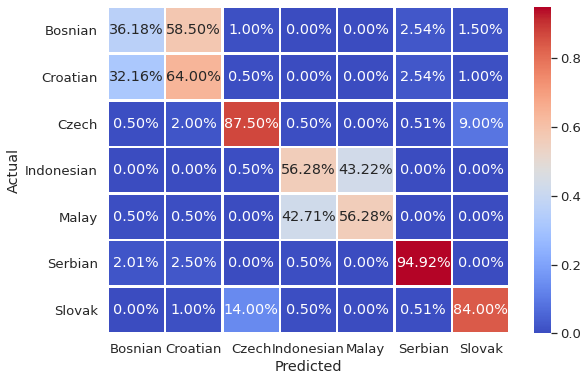

Training:
 ####################  100.0 %  42s epoch: 3000 loss: 0.0568] Making 3-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 7m 49s 
Creating Encoding for Y
Encoding completed at 0m 6s
Accuracy is 68.72309875488281%
f1-score is 0.6841346010824382


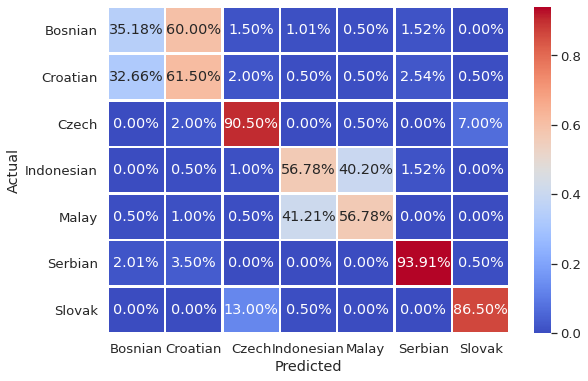

Training:
 ####################  100.0 %  10s epoch: 5000 loss: 0.0743] Making 3-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 17m 17s 
Creating Encoding for Y
Encoding completed at 0m 6s
Accuracy is 70.01434326171875%
f1-score is 0.6955207271848703


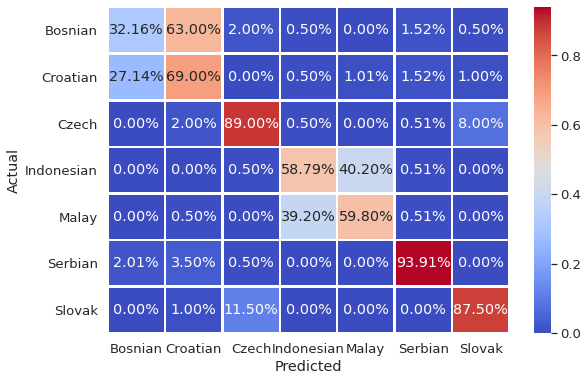

Training:
 ####################  100.0 %  10s epoch: 1000 loss: 0.3174] Making 3-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 19m 17s 
Creating Encoding for Y
Encoding completed at 0m 6s
Accuracy is 68.57962799072266%
f1-score is 0.6784936983071163


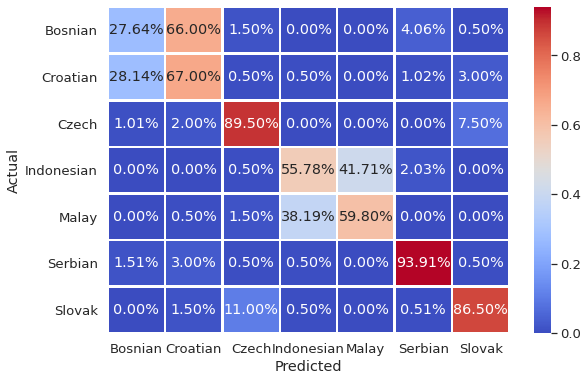

Training:
 ####################  100.0 %  29s epoch: 1000 loss: 0.0813] Making 3-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 21m 35s 
Creating Encoding for Y
Encoding completed at 0m 6s
Accuracy is 67.28838348388672%
f1-score is 0.6673100857584453


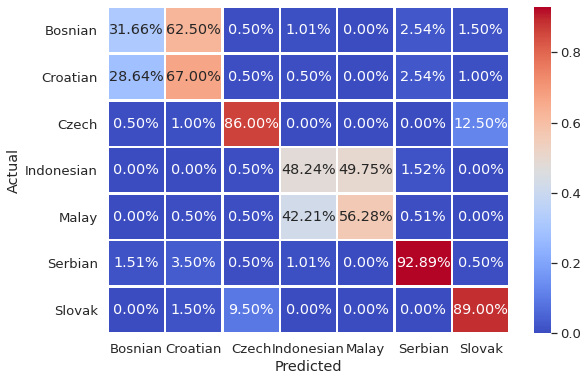

Training:
 ####################  100.0 %  47s epoch: 1000 loss: 0.0552] Making 3-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 23m 54s 
Creating Encoding for Y
Encoding completed at 0m 6s
Accuracy is 69.01004028320312%
f1-score is 0.686506871805036


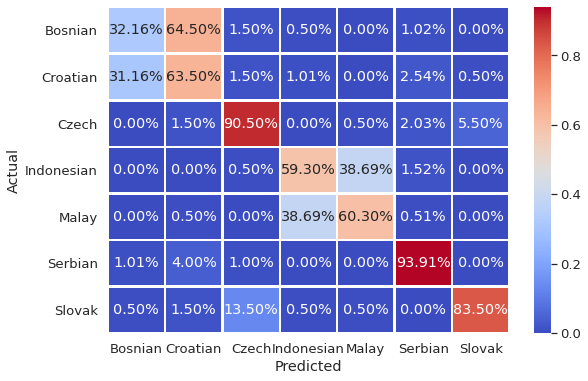

Training:
 ####################  100.0 %  48s epoch: 1000 loss: 0.1159] Making 3-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 25m 54s 
Creating Encoding for Y
Encoding completed at 0m 6s
Accuracy is 69.58393096923828%
f1-score is 0.6885182600742082


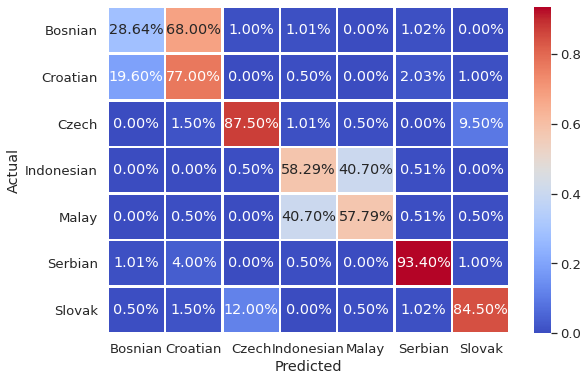

Training:
 ####################  100.0 %  15s epoch: 1000 loss: 0.1871] Making 3-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 28m 21s 
Creating Encoding for Y
Encoding completed at 0m 6s
Accuracy is 67.71879577636719%
f1-score is 0.670890472220256


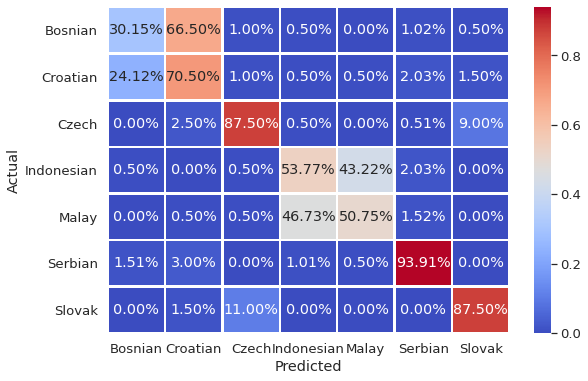

Training:
 ####################  100.0 %  57s epoch: 1000 loss: 2.6002] Making 3-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 31m 4s 
Creating Encoding for Y
Encoding completed at 0m 6s
Accuracy is 68.93830871582031%
f1-score is 0.6823974496827936


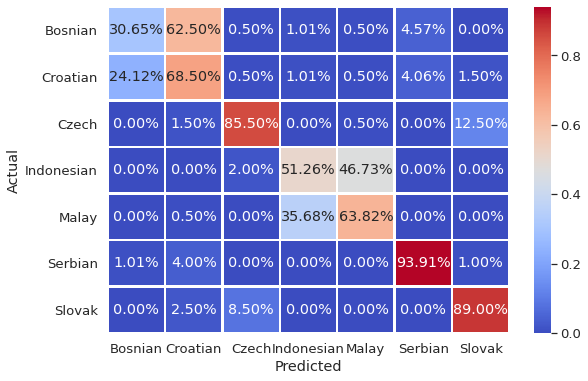

Training:
 ####################  100.0 %  57s epoch: 1000 loss: 0.3333] Making 3-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 33m 4s 
Creating Encoding for Y
Encoding completed at 0m 6s
Accuracy is 67.86226654052734%
f1-score is 0.6726781063872248


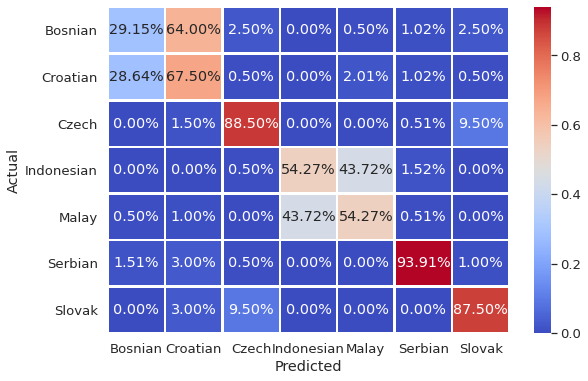

Training:
 ####################  100.0 %  58s epoch: 1000 loss: 0.0708] Making 3-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 35m 4s 
Creating Encoding for Y
Encoding completed at 0m 6s
Accuracy is 67.93399810791016%
f1-score is 0.6738293414601764


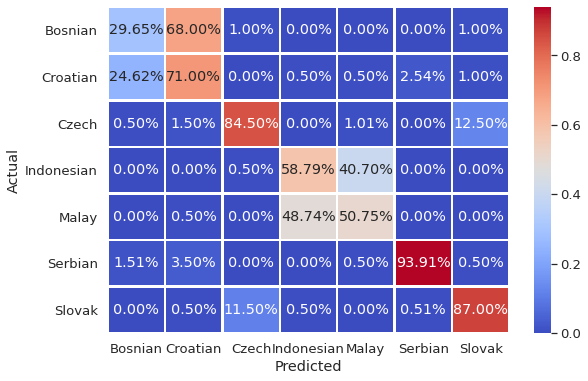

Training:
 ####################  100.0 %  58s epoch: 1000 loss: 0.0613] Making 3-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 37m 5s 
Creating Encoding for Y
Encoding completed at 0m 6s
Accuracy is 68.57962799072266%
f1-score is 0.6831815248991414


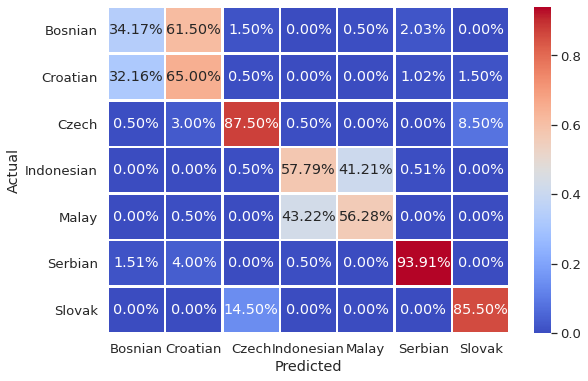

Training:
 ####################  100.0 %  58s epoch: 1000 loss: 11.1024] Making 3-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 39m 5s 
Creating Encoding for Y
Encoding completed at 0m 7s
Accuracy is 64.56240844726562%
f1-score is 0.6374962163276191


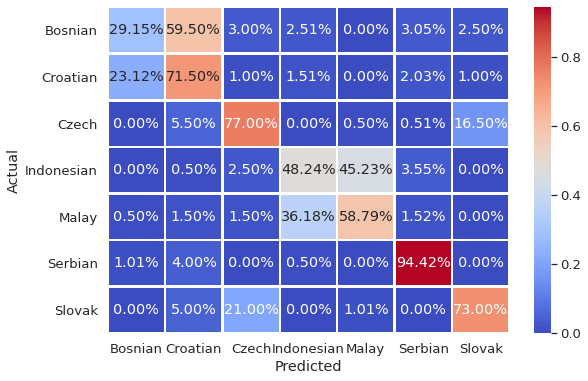

Training:
 ####################  100.0 %  59s epoch: 1000 loss: 11.3965] Making 3-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 41m 6s 
Creating Encoding for Y
Encoding completed at 0m 7s
Accuracy is 64.41893768310547%
f1-score is 0.6231141323528202


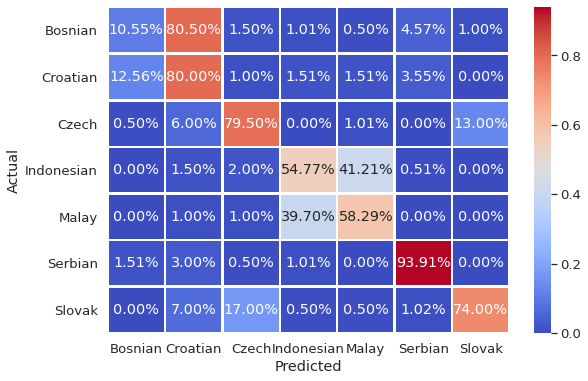

Preparing 200 samples per language
Making 5-grams at 0m 0s ..
Extracting 10 features at 0m 0s ...
Creating Encoding for X
100% data prepared at time 0m 6s 
Creating Encoding for Y
Training:
 ####################  100.0 %  29s epoch: 1000 loss: 1.6881] Making 5-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 1m 36s 
Creating Encoding for Y
Encoding completed at 0m 7s
Accuracy is 69.4510726928711%
f1-score is 0.6868665619675205


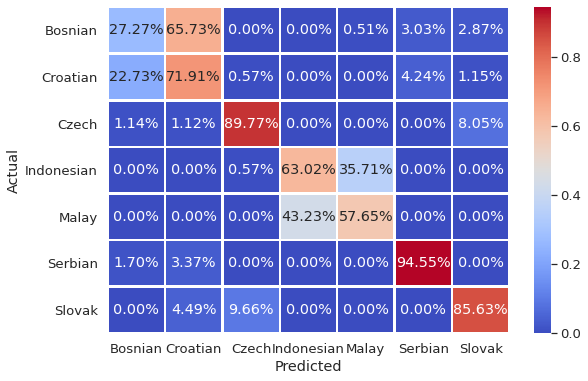

Training:
 ####################  100.0 %  46s epoch: 3000 loss: 1.4050] Making 5-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 5m 53s 
Creating Encoding for Y
Encoding completed at 0m 7s
Accuracy is 70.326171875%
f1-score is 0.6926856514130897


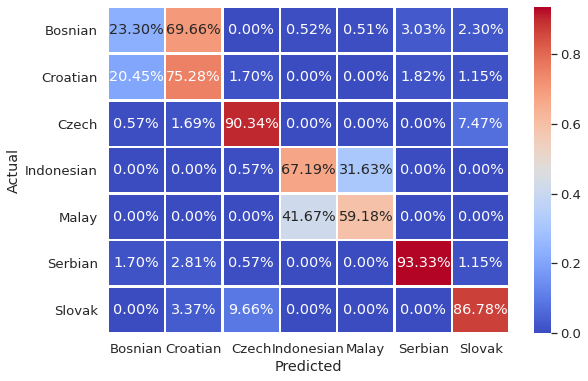

Training:
 ####################  100.0 %  47s epoch: 5000 loss: 1.3701] Making 5-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 12m 54s 
Creating Encoding for Y
Encoding completed at 0m 7s
Accuracy is 69.76929473876953%
f1-score is 0.6913611034633528


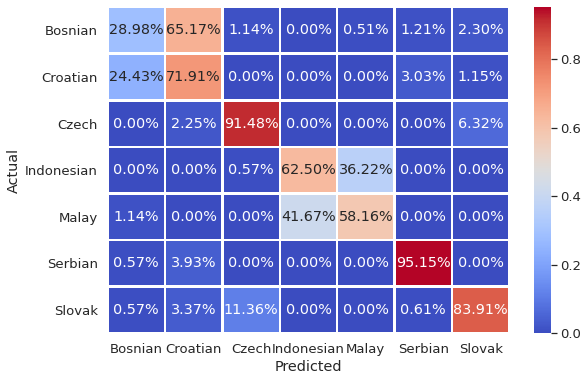

Training:
 ####################  100.0 %  18s epoch: 1000 loss: 1.6510] Making 5-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 14m 26s 
Creating Encoding for Y
Encoding completed at 0m 7s
Accuracy is 69.13285827636719%
f1-score is 0.6883335647040636


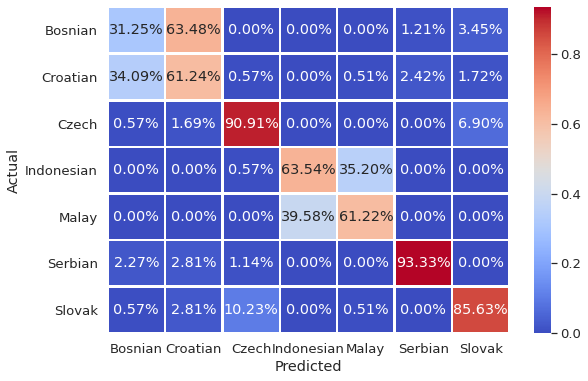

Training:
 ####################  100.0 %  2s epoch: 1000 loss: 1.5034] Making 5-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 16m 9s 
Creating Encoding for Y
Encoding completed at 0m 7s
Accuracy is 69.68973541259766%
f1-score is 0.6951788040915895


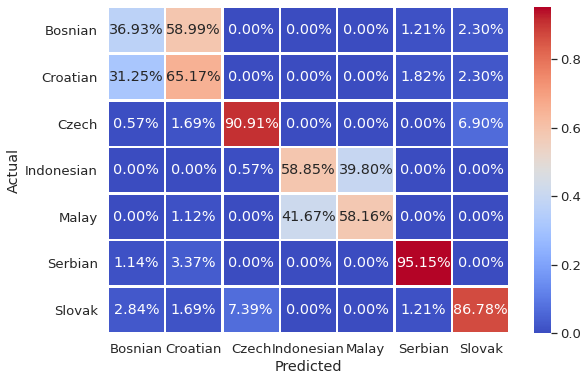

Training:
 ####################  100.0 %  52s epoch: 1000 loss: 1.4385] Making 5-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 18m 0s 
Creating Encoding for Y
Encoding completed at 0m 7s
Accuracy is 70.08750915527344%
f1-score is 0.6978496230098786


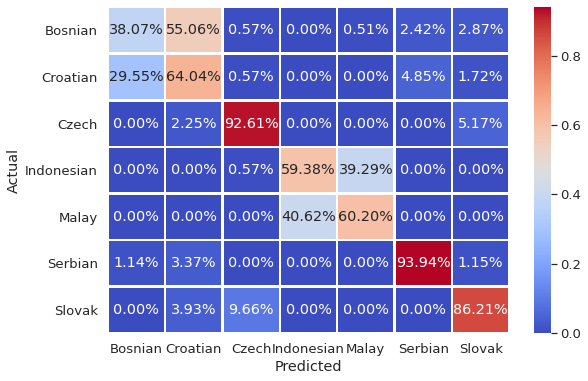

Training:
 ####################  100.0 %  24s epoch: 1000 loss: 1.6007] Making 5-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 19m 31s 
Creating Encoding for Y
Encoding completed at 0m 7s
Accuracy is 68.57597351074219%
f1-score is 0.6828304106770358


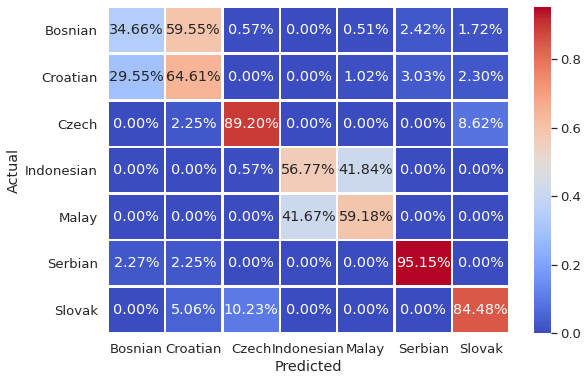

Training:
 ####################  100.0 %  16s epoch: 1000 loss: 1.7428] Making 5-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 21m 23s 
Creating Encoding for Y
Encoding completed at 0m 7s
Accuracy is 69.2919692993164%
f1-score is 0.6882272594357115


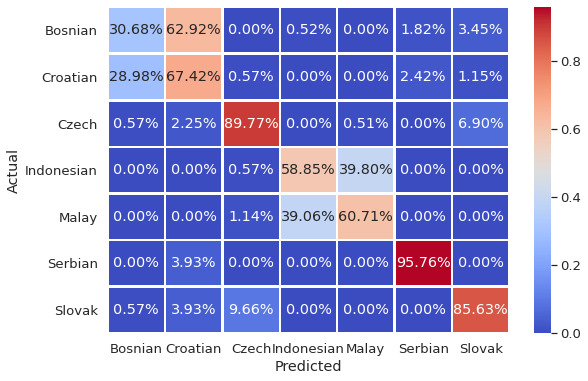

Training:
 ####################  100.0 %  29s epoch: 1000 loss: 1.7160] Making 5-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 23m 36s 
Creating Encoding for Y
Encoding completed at 0m 7s
Accuracy is 69.4510726928711%
f1-score is 0.6922751642886424


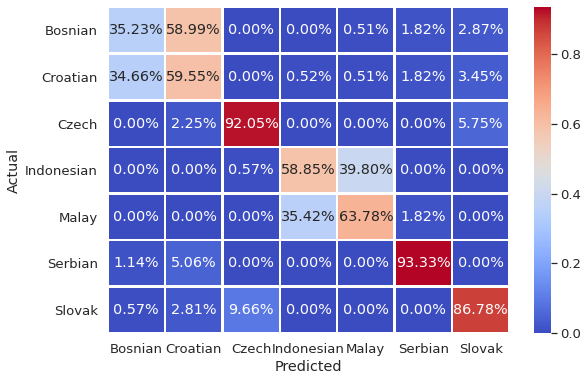

Training:
 ####################  100.0 %  0s epoch: 1000 loss: 1.8520] Making 5-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 25m 8s 
Creating Encoding for Y
Encoding completed at 0m 7s
Accuracy is 71.04216003417969%
f1-score is 0.7073841417646204


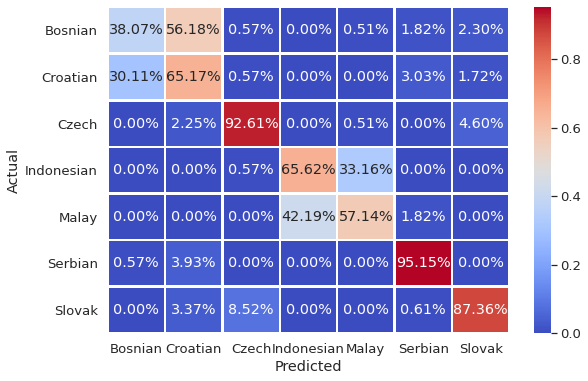

Training:
 ####################  100.0 %  32s epoch: 1000 loss: 1.3676] Making 5-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 26m 39s 
Creating Encoding for Y
Encoding completed at 0m 7s
Accuracy is 70.56483459472656%
f1-score is 0.6993503867706989


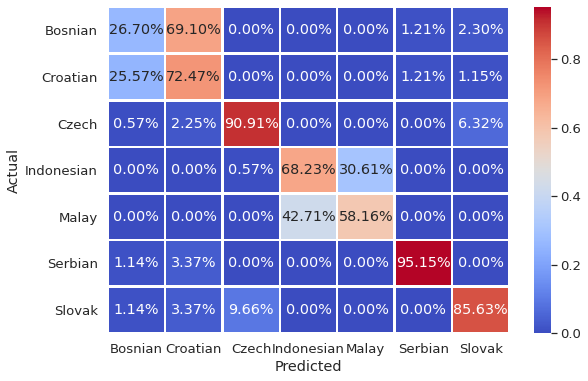

Training:
 ####################  100.0 %  3s epoch: 1000 loss: 1.3969] Making 5-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 28m 11s 
Creating Encoding for Y
Encoding completed at 0m 7s
Accuracy is 70.56483459472656%
f1-score is 0.6990851753436413


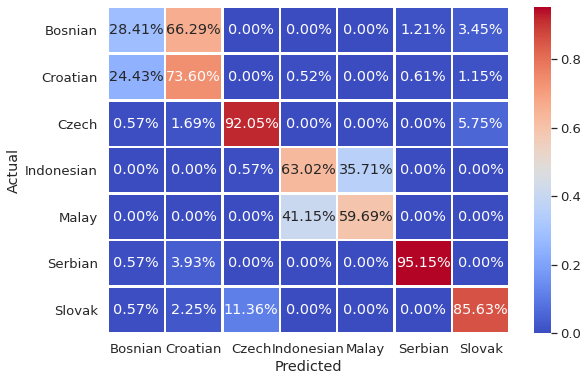

Training:
 ####################  100.0 %  35s epoch: 1000 loss: 4.8581] Making 5-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 29m 42s 
Creating Encoding for Y
Encoding completed at 0m 7s
Accuracy is 70.56483459472656%
f1-score is 0.6952464028659437


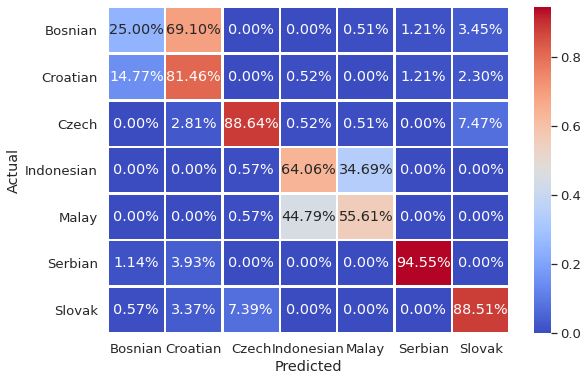

Training:
 ####################  100.0 %  7s epoch: 1000 loss: 5.9234] Making 5-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 31m 14s 
Creating Encoding for Y
Encoding completed at 0m 7s
Accuracy is 70.96260833740234%
f1-score is 0.6958254070129236


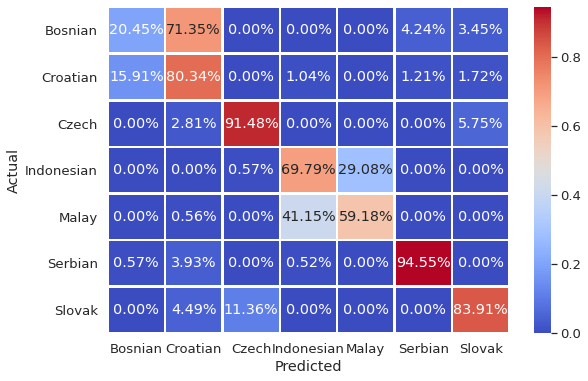

Preparing 200 samples per language
Making 8-grams at 0m 0s ..
Extracting 10 features at 0m 0s ...
Creating Encoding for X
100% data prepared at time 0m 6s 
Creating Encoding for Y
Training:
 ####################  100.0 %  56s epoch: 1000 loss: 3.1230] Making 8-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 1m 4s 
Creating Encoding for Y
Encoding completed at 0m 7s
Accuracy is 69.11357116699219%
f1-score is 0.6571883223058619


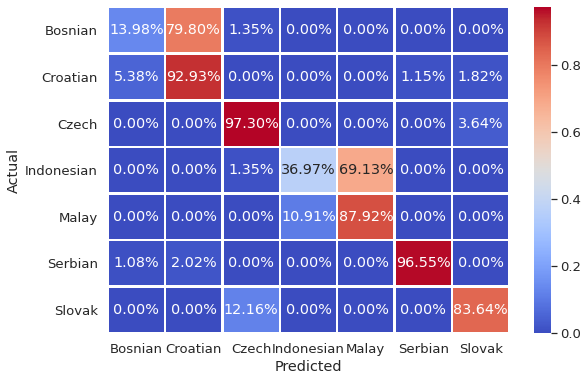

Training:
 ####################  100.0 %  34s epoch: 3000 loss: 3.0557] Making 8-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 3m 41s 
Creating Encoding for Y
Encoding completed at 0m 7s
Accuracy is 68.28254699707031%
f1-score is 0.668709598499476


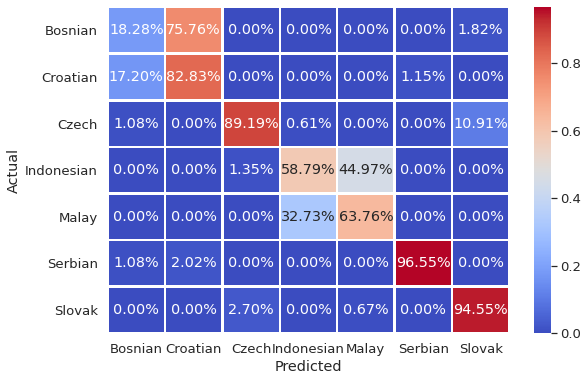

Training:
 ####################  100.0 %  50s epoch: 5000 loss: 2.9709] Making 8-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 7m 57s 
Creating Encoding for Y
Encoding completed at 0m 7s
Accuracy is 66.20498657226562%
f1-score is 0.6465730040822855


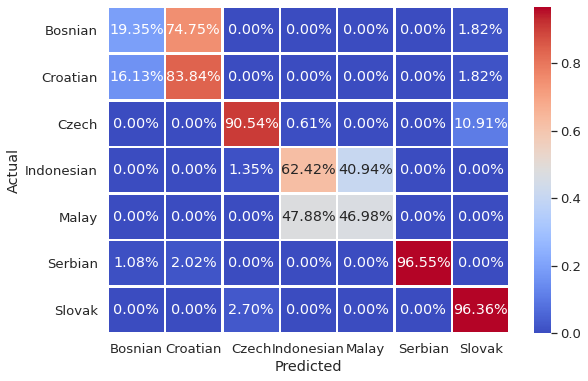

Training:
 ####################  100.0 %  48s epoch: 1000 loss: 3.0757] Making 8-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 8m 55s 
Creating Encoding for Y
Encoding completed at 0m 7s
Accuracy is 68.00553894042969%
f1-score is 0.6545069913769327


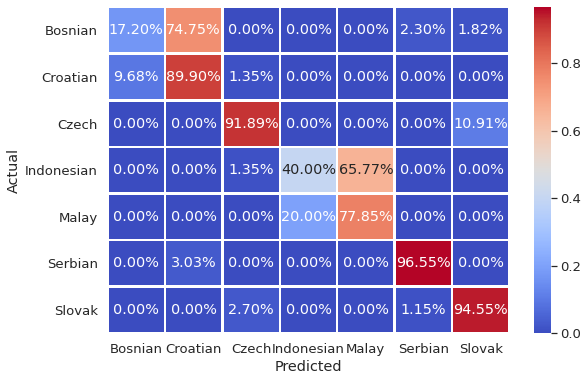

Training:
 ####################  100.0 %  53s epoch: 1000 loss: 2.9935] Making 8-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 10m 1s 
Creating Encoding for Y
Encoding completed at 0m 7s
Accuracy is 67.86703491210938%
f1-score is 0.6571416212998311


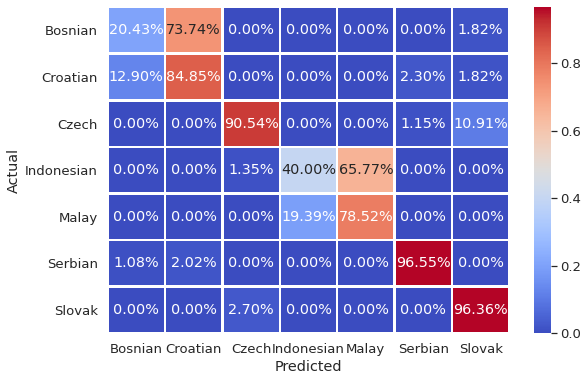

Training:
 ####################  100.0 %  6s epoch: 1000 loss: 2.9956] Making 8-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 11m 13s 
Creating Encoding for Y
Encoding completed at 0m 7s
Accuracy is 67.72853088378906%
f1-score is 0.6583519365621852


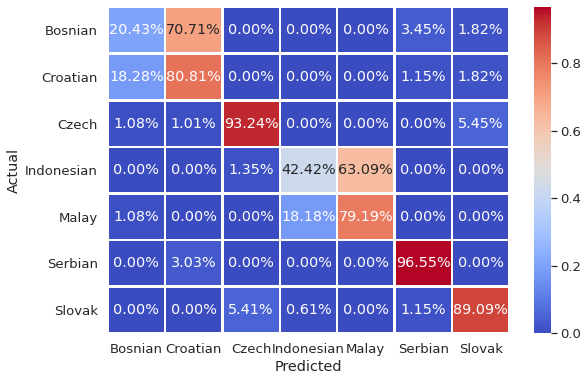

Training:
 ####################  100.0 %  4s epoch: 1000 loss: 3.0424] Making 8-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 12m 11s 
Creating Encoding for Y
Encoding completed at 0m 7s
Accuracy is 66.48199462890625%
f1-score is 0.6413498841944019


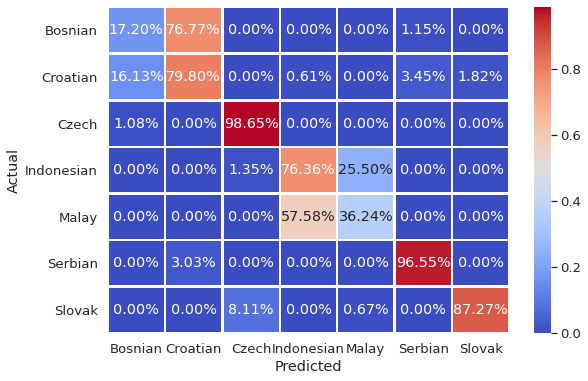

Training:
 ####################  100.0 %  14s epoch: 1000 loss: 3.0766] Making 8-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 13m 22s 
Creating Encoding for Y
Encoding completed at 0m 7s
Accuracy is 68.55955505371094%
f1-score is 0.6562087090990809


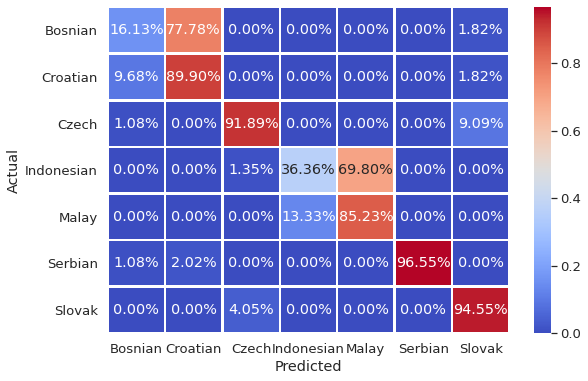

Training:
 ####################  100.0 %  40s epoch: 1000 loss: 3.0931] Making 8-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 14m 47s 
Creating Encoding for Y
Encoding completed at 0m 7s
Accuracy is 68.00553894042969%
f1-score is 0.6493403381407747


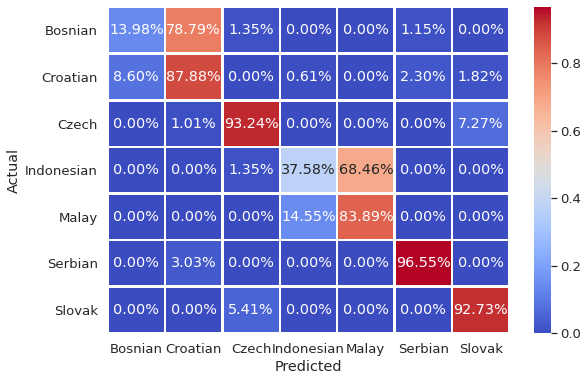

Training:
 ####################  100.0 %  38s epoch: 1000 loss: 3.1408] Making 8-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 15m 46s 
Creating Encoding for Y
Encoding completed at 0m 7s
Accuracy is 68.55955505371094%
f1-score is 0.6560611422749701


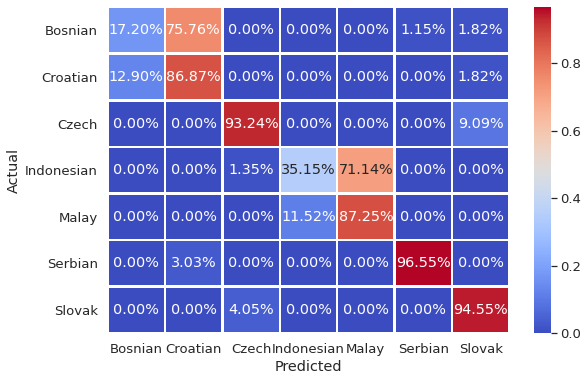

Training:
 ####################  100.0 %  37s epoch: 1000 loss: 2.9732] Making 8-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 16m 44s 
Creating Encoding for Y
Encoding completed at 0m 7s
Accuracy is 68.00553894042969%
f1-score is 0.6579867137422505


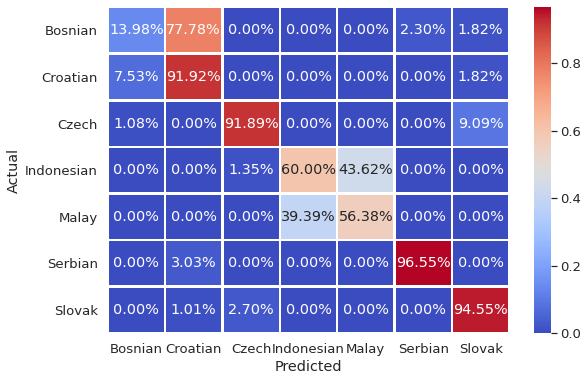

Training:
 ####################  100.0 %  35s epoch: 1000 loss: 3.0141] Making 8-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 17m 43s 
Creating Encoding for Y
Encoding completed at 0m 7s
Accuracy is 66.48199462890625%
f1-score is 0.6444935674458121


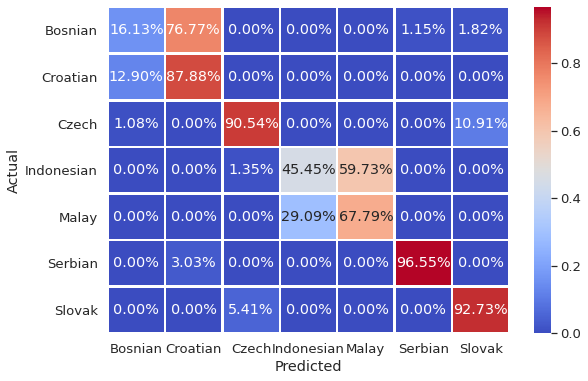

Training:
 ####################  100.0 %  34s epoch: 1000 loss: 4.5118] Making 8-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 18m 41s 
Creating Encoding for Y
Encoding completed at 0m 7s
Accuracy is 64.8199462890625%
f1-score is 0.630339609499687


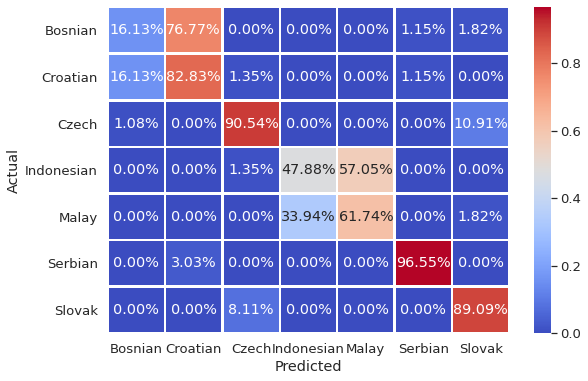

Training:
 ####################  100.0 %  32s epoch: 1000 loss: 4.9262] Making 8-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 19m 39s 
Creating Encoding for Y
Encoding completed at 0m 7s
Accuracy is 64.8199462890625%
f1-score is 0.6290420645695043


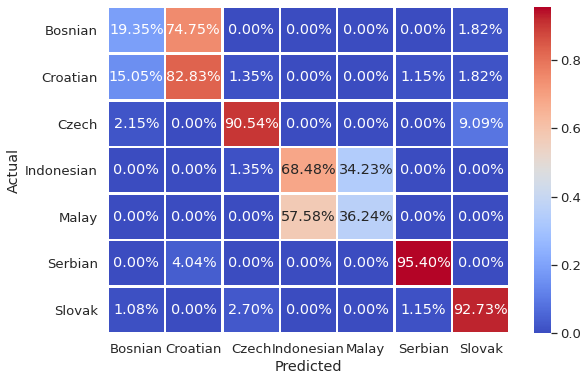

In [206]:

gram_log = defaultdict(dict)

n_gram_list = [3,5,8]
n_instance = 200
n_feature = 10
parameters = {'n_epochs':[1000,3000,5000],'hidden_size':[64,128,256],'n_layers':[1,2,3],'lr':[0.001,0.005,0.01,0.05,0.1]}
X_Train, Y_Train = preprocess(X_train[:-1], Y_train[:-1])
X_Test, Y_Test = preprocess(X_test[:-1], Y_test[:-1])

for n_gram in n_gram_list:
  param_log = defaultdict(lambda: defaultdict(list))
  start = time.time()
  vocab, inp, target = prepare_data(X_Train, Y_Train, n_instance, n_gram, n_feature, dsl_groups_ABC)
  input_size = len(vocab)
  x_test, y_test = get_data_chunk(X_Test, Y_Test, n_instance,dsl_groups_ABC)
  for key,value in parameters.items():
      for val in value:
          args = {key:val}
          model, losses, scores = start_training(inp, target, input_size, **args)
          param_log[key]['losses'].append(losses)
          param_log[key]['f1_score'].append(scores)
          acc = test_model(model, x_test, y_test, n_gram, vocab)
          param_log[key]['accuracy'].append(acc)
  gram_log[n_gram] = param_log

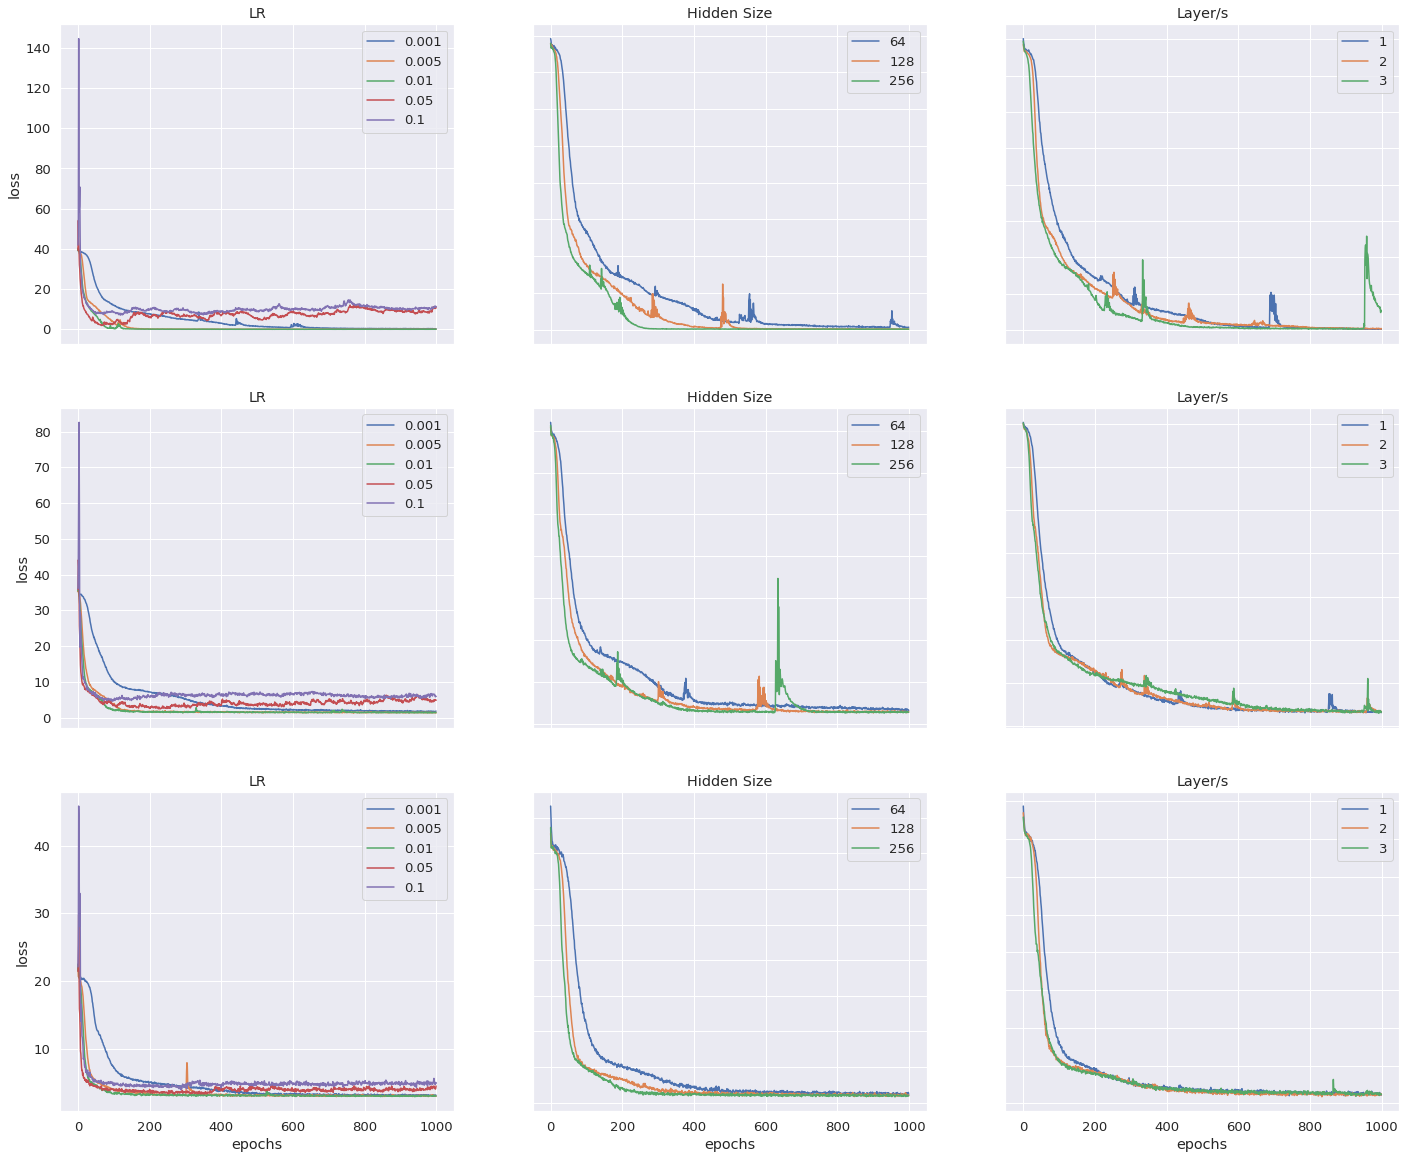

In [207]:
fig, axs = plt.subplots(3, 3,figsize = (24,20))
for i in range(0,3):
  
  gram = n_gram_list[i]
  data = gram_log[gram]
  for j in range(0,3):
    if j == 0 :
      col = 'lr'
      axs[i, j].set_title('LR')
    elif j == 1:
      col = 'hidden_size'
      axs[i, j].set_title('Hidden Size')
    elif j == 2:
      col = 'n_layers'
      axs[i, j].set_title('Layer/s')
    lst = data[col]['losses']
    for val in lst:
      axs[i,j].plot(val)
      axs[i,j].legend(parameters[col])
  
for ax in axs.flat:
    ax.set(xlabel='epochs', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

Comparison to benchmark modules **langdetect** and **LangID**:

In [ ]:
#%pip install langdetect

In [208]:

from langdetect import detect_langs
from langdetect import detect

def convertcode(lang, towiki=True):
  if towiki==True:
    lang = labels['Wiki Code'].where(labels['English'] == lang).dropna().values[0]
  else:
    lang = labels['English'].where(labels['Wiki Code'] == lang).dropna().values[0]
  return lang

knownlangs = ('af, ar, bg, bn, ca, cs, cy, da, de, el, en, es, et, fa, fi, fr, gu, he, hi, hr, hu, id, it, ja, kn, ko, lt, lv, mk, ml, mr, ne, nl, no, pa, pl, pt, ro, ru, sk, sl, so, sq, sv, sw, ta, te, th, tl, tr, uk, ur, vi, zh-cn, zh-tw').split(", ")
#print(knownlangs)
languages = dsl_groups_ABCG
languageswiki = [convertcode(i, towiki=True) for i in languages]
languageswiki = list(set(languageswiki).intersection(knownlangs))
usedlangs = [convertcode(i, towiki=False) for i in languageswiki]

print(usedlangs)


['Macedonian', 'Indonesian', 'Croatian', 'Bulgarian', 'Slovak', 'Czech']


In [228]:
n_instances = [200]
ldcorrect = 0
nlanguages = len(usedlangs)
y_pred = []

for n_instance in n_instances:

  x_test, y_test = get_data_chunk(X_Test, Y_Test, n_instance, usedlangs)
  for x, y in zip(x_test, y_test):
    y = convertcode(y)
    y_prd = detect(x)
    if y_prd == y:
      ldcorrect += 1
      y_pred.append(convertcode(y_prd, False))
    elif convertcode(y_prd, towiki=False) not in usedlangs:
      y_prd = 'other'
      y_pred.append(y_prd)
    else:
      print(y_prd, y)
      y_pred.append(convertcode(y_prd, False))
  print("Accuracy of langdetect with",n_instance,"paragraphs per language = ",ldaccuracy)

y_pred.append('other')
y_test.append('other')

cs id
Accuracy of langdetect with 200 paragraphs per language =  0.975


In [229]:
ldcf_mat = confusion_matrix(y_test, y_pred)

print(ldcf_mat)
ldf1score = f1_score(y_test,y_pred,average='weighted')
print(f"f1-score is {ldf1score}")

[[193   0   0   0   0   0   7]
 [  0 198   0   0   0   0   2]
 [  0   0 197   0   0   0   3]
 [  0   0   1 190   0   0   9]
 [  0   0   0   0 195   0   5]
 [  0   0   0   0   0 197   3]
 [  0   0   0   0   0   0   1]]
f1-score is 0.9861081715860174


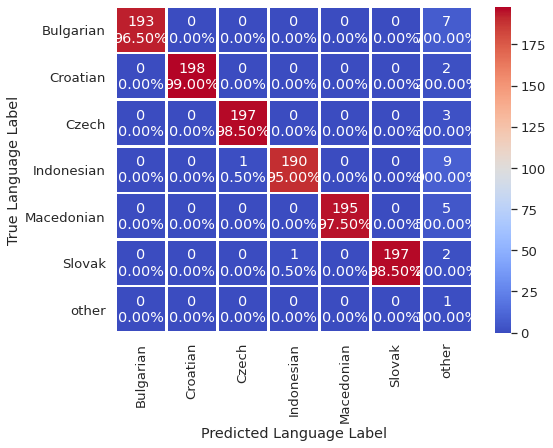

In [223]:
### LangDetect heatmap

# code for heatmaps:
group_counts = ["{0:0.0f}\n".format(value) for value in ldcf_mat.flatten()]
# we want percentages to show % of predictions in each true cell, which means the the sums should be done by row
group_percentages = ["{0:.2%}".format(value) for value in (ldcf_mat/ldcf_mat.sum(axis=1)).flatten()]
box_labels = [f"{v1}{v2}".strip() for v1, v2 in zip(group_counts, group_percentages)]    
box_labels = np.asarray(box_labels).reshape(ldcf_mat.shape[0], ldcf_mat.shape[1])
plt.subplots(figsize=(8,6))

sns.heatmap(ldcf_mat, cmap='coolwarm', annot=box_labels, fmt="", linewidths=1.5, xticklabels=np.unique(y_pred), yticklabels=np.unique(y_pred))
plt.xlabel("Predicted Language Label")
plt.ylabel("True Language Label")
plt.show()

In [213]:
%pip install langid

     |████████████████████████████████| 1.9MB 4.1MB/s 
  Created wheel for langid: filename=langid-1.1.6-cp37-none-any.whl size=1941191 sha256=ef0cedca00701ad206616ca910c8336c379ddb24d0604d80b722caf93d2340c9
  Stored in directory: /root/.cache/pip/wheels/29/bc/61/50a93be85d1afe9436c3dc61f38da8ad7b637a38af4824e86e
Successfully built langid


In [226]:
import langid

langid.set_languages(languageswiki)
n_instances = [200]
lidcorrect = 0
nlanguages = len(languageswiki)
y_pred = []

for n_instance in n_instances:

  x_test, y_test = get_data_chunk(X_Test, Y_Test, n_instance, usedlangs)
  for x, y in zip(x_test, y_test):
    y = convertcode(y)
    #print(x[:50], "... \nLanguage:", y)
    y_prd = langid.classify(x)[0]
    #print("y_pred =", detect(x))
    if y_prd == y:
      lidcorrect += 1
      
    y_pred.append(convertcode(y_prd, False))

  lidaccuracy = lidcorrect/(nlanguages*n_instance)
  print("Accuracy of langid with",n_instance,"paragraphs per language = ",lidaccuracy)

lidcf_mat = confusion_matrix(y_test, y_pred)
lidf1score = f1_score(y_test,y_pred,average='weighted')
print(f"f1-score is {lidf1score}")

Accuracy of langid with 200 paragraphs per language =  0.9825
f1-score is 0.9826514358544326


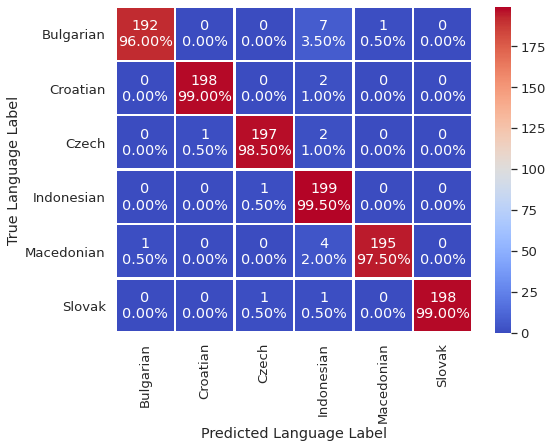

In [220]:
### LangID heatmap

# code for heatmaps:
group_counts = ["{0:0.0f}\n".format(value) for value in lidcf_mat.flatten()]
# we want percentages to show % of predictions in each true cell, which means the the sums should be done by row
group_percentages = ["{0:.2%}".format(value) for value in (lidcf_mat/lidcf_mat.sum(axis=1)).flatten()]
box_labels = [f"{v1}{v2}".strip() for v1, v2 in zip(group_counts, group_percentages)]    
box_labels = np.asarray(box_labels).reshape(lidcf_mat.shape[0], lidcf_mat.shape[1])
plt.subplots(figsize=(8,6))

sns.heatmap(lidcf_mat, cmap='coolwarm', annot=box_labels, fmt="", linewidths=1.5, xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Language Label")
plt.ylabel("True Language Label")
plt.show()

Preparing 200 samples per language
Making 3-grams at 0m 0s ..
Extracting 10 features at 0m 0s ...
Creating Encoding for X
100% data prepared at time 0m 6s 
Creating Encoding for Y
Training Phase..
Training:
 ####################  100.0 %  5s epoch: 1000 loss: 0.0818] Making 3-grams at 0m 0s ..
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
100% data prepared at time 1m 11s 
Creating Encoding for Y
Encoding completed at 0m 6s
Accuracy is 79.26421356201172%
f1-score is 0.7483212195666046


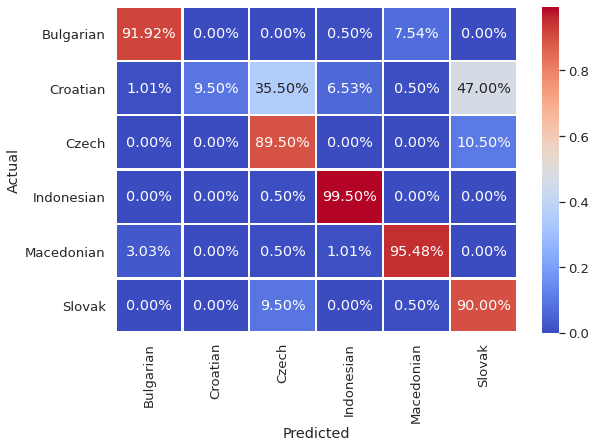

RNN accuracy = tensor(79.2642)


In [224]:
### Now we try our RNN on the same language set, and achieve 79.2% accuracy. 
### We consider the following hyperparameters to be the optimal choices, considering the evaluation section above.

X_Train, Y_Train = preprocess(X_train[:-1], Y_train[:-1])
X_Test, Y_Test = preprocess(X_test[:-1], Y_test[:-1])

n_instance = 200 
n_gram_size = 3
n_feature = 10

start = time.time()
vocab, inp, target = prepare_data(X_Train, Y_Train, n_instance, n_gram_size, n_feature, usedlangs)

print('Training Phase..')
hidden_size = 64
input_size = len(vocab) # Number of grams in vocabulary
n_layers = 1 # Number of layers of RNN
embedding_size = 64
lr = 0.001
batch = 100
n_epochs = 1000

model, losses, scores = start_training(inp, target, input_size, hidden_size, n_layers, embedding_size, lr, batch, n_epochs)

x_test, y_test = get_data_chunk(X_Test, Y_Test, n_instance, usedlangs)
accuracy = test_model(model, x_test, y_test, n_gram_size, vocab)
